This notebook shows you how to visualize the changes in ozone and particulate matter from different runs of CCTM. Note that you must first run the `combine` program distributed with CMAQ for the files here to exist. The need for postprocessing of CCTM outputs is explained in [this section](https://github.com/USEPA/CMAQ/blob/main/DOCS/Users_Guide/CMAQ_UG_ch08_analysis_tools.md#82-aggregating-and-transforming-model-species) of the CMAQ User's Guide.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from cmaqpy.runcmaq import CMAQModel
from cmaqpy import plots

import monet as m
import monetio as mio

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


Please install s3fs if retrieving from the Amazon S3 Servers.  Otherwise continue with local data
Please install h5netcdf to open files from the Amazon S3 servers.


In [2]:
# Specify the start/end times
start_datetime = 'August 06, 2016'  # first day that you want run
end_datetime = 'August 14, 2016'  # last day you want run
# Define the coordinate name (must match that in GRIDDESC)
coord_name = 'LAM_40N97W'
# Create a CMAQModel object
base_sim = CMAQModel(start_datetime, end_datetime, '2016Base_12OTC2', coord_name, '12OTC2', verbose=True)
s0_sim = CMAQModel(start_datetime, end_datetime, '2016_12OTC2', coord_name, '12OTC2', verbose=True)

Application name: 2016Base_12OTC2
Coordinate name: LAM_40N97W
Grid name: 12OTC2
CCTM RUNID: v533_gcc9.3.1_2016Base_12OTC2
CMAQ run starting on: 2016-08-06 00:00:00
CMAQ run ending on: 2016-08-14 00:00:00
Application name: 2016_12OTC2
Coordinate name: LAM_40N97W
Grid name: 12OTC2
CCTM RUNID: v533_gcc9.3.1_2016_12OTC2
CMAQ run starting on: 2016-08-06 00:00:00
CMAQ run ending on: 2016-08-14 00:00:00


In [44]:
emis_dir = '/share/mzhang/jas983/emissions_data/nei_platform2016/v1/2016fh_16j/smoke_out/2016fh_16j/12OTC2/cmaq_cb6/'
emis_base1 = f'{emis_dir}/ptertac/2d_mole_ptertac_20160812_12OTC2_cmaq_cb6_2016fh_16j.ncf'
# emis_base2 = f'{emis_dir}/ptertac/2d_mole_ptertac_20160814_12OTC2_cmaq_cb6_2016fh_16j.ncf'
emis_s0_1 = f'{emis_dir}/ptertac_s0/2d_mole_ptertac_20160812_12OTC2_cmaq_cb6_2016fh_16j.ncf'
# emis_s0_2 = f'{emis_dir}/ptertac_s0/2d_mole_ptertac_20160814_12OTC2_cmaq_cb6_2016fh_16j.ncf'
e_base = mio.cmaq.open_dataset(fname=emis_base1)
# e_base2 = mio.cmaq.open_dataset(fname=emis_base2)
# e_base = xr.concat([e_base1, e_base2], dim='time')
e = mio.cmaq.open_dataset(fname=emis_s0_1)
# e2 = mio.cmaq.open_dataset(fname=emis_s0_2)
# e = xr.concat([e1, e2], dim='time')

<xarray.Dataset>
Dimensions:       (COL: 273, DATE-TIME: 2, LAY: 1, ROW: 246, TSTEP: 25, VAR: 58)
Dimensions without coordinates: COL, DATE-TIME, LAY, ROW, TSTEP, VAR
Data variables: (12/61)
    TFLAG         (TSTEP, VAR, DATE-TIME) int32 ...
    BUTADIENE13   (TSTEP, LAY, ROW, COL) float32 ...
    ACROLEIN      (TSTEP, LAY, ROW, COL) float32 ...
    HCL           (TSTEP, LAY, ROW, COL) float32 ...
    CL2           (TSTEP, LAY, ROW, COL) float32 ...
    CO            (TSTEP, LAY, ROW, COL) float32 ...
    ...            ...
    TOL           (TSTEP, LAY, ROW, COL) float32 ...
    UNR           (TSTEP, LAY, ROW, COL) float32 ...
    XYLMN         (TSTEP, LAY, ROW, COL) float32 ...
    VOC_INV       (TSTEP, LAY, ROW, COL) float32 ...
    NOy           (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NOx           (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/34)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 200 2021-05-10 14:06:20Z coat

In [45]:
def convert_tz_xr(df, input_tz='UTC', output_tz='US/Eastern'):
    tidx_in = df.time.to_index().tz_localize(tz=input_tz)
    df.coords['time'] = tidx_in.tz_convert(output_tz).tz_localize(None)
    return df

In [46]:
e = convert_tz_xr(e)
e_base = convert_tz_xr(e_base)

In [47]:
e

<xarray.Dataset>
Dimensions:       (DATE-TIME: 2, VAR: 58, time: 25, x: 273, y: 246, z: 1)
Coordinates:
  * time          (time) datetime64[ns] 2016-08-11T20:00:00 ... 2016-08-12T20...
    longitude     (y, x) float64 -106.0 -105.9 -105.8 ... -65.29 -65.14 -64.99
    latitude      (y, x) float64 25.18 25.19 25.2 25.21 ... 48.31 48.28 48.24
Dimensions without coordinates: DATE-TIME, VAR, x, y, z
Data variables: (12/61)
    TFLAG         (time, VAR, DATE-TIME) int32 ...
    BUTADIENE13   (time, z, y, x) float32 ...
    ACROLEIN      (time, z, y, x) float32 ...
    HCL           (time, z, y, x) float32 ...
    CL2           (time, z, y, x) float32 ...
    CO            (time, z, y, x) float32 ...
    ...            ...
    TOL           (time, z, y, x) float32 ...
    UNR           (time, z, y, x) float32 ...
    XYLMN         (time, z, y, x) float32 ...
    VOC_INV       (time, z, y, x) float32 ...
    NOy           (time, z, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NOx           (time, z, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/34)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 200 2021-05-10 14:06:20Z coats ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2022078
    CTIME:          200232
    WDATE:          2022078
    ...             ...
    GDNAM:          12OTC2          
    UPNAM:          INLINETO2D      
    VAR-LIST:       BUTADIENE13     ACROLEIN        HCL             CL2      ...
    FILEDESC:       Point  source stack groups file                          ...
    HISTORY:        
    proj4_srs:      +proj=lcc +lat_1=33.0 +lat_2=45.0 +lat_0=40.0 +lon_0=-97....

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


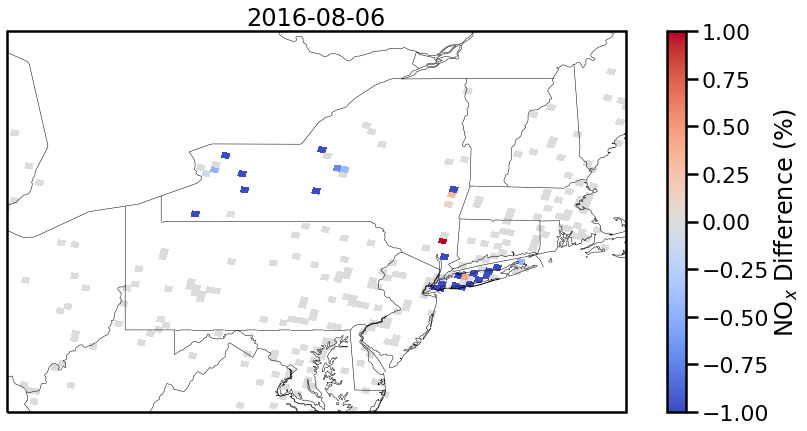

In [8]:
# Plot the mean difference in NOx
nox_pct_diff = ((e1.NO + e1.NO2) - (e.NO + e.NO2)) / ((e1.NO + e1.NO2 + e.NO + e.NO2)/2) * 100
mean_nox_diff = nox_pct_diff.mean(dim='time')
plots.pollution_plot(mean_nox_diff, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm'), 
                     extent = [-83, -70, 38, 46],
                     cbar_label='NO$_{x}$ Difference (%)', 
                     titlestr=f'{e1.time.dt.strftime("%Y-%m-%d")[0].values}', savefig=True, figpath=f'../cmaqpy/data/plots/mean_NOx_diff_.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


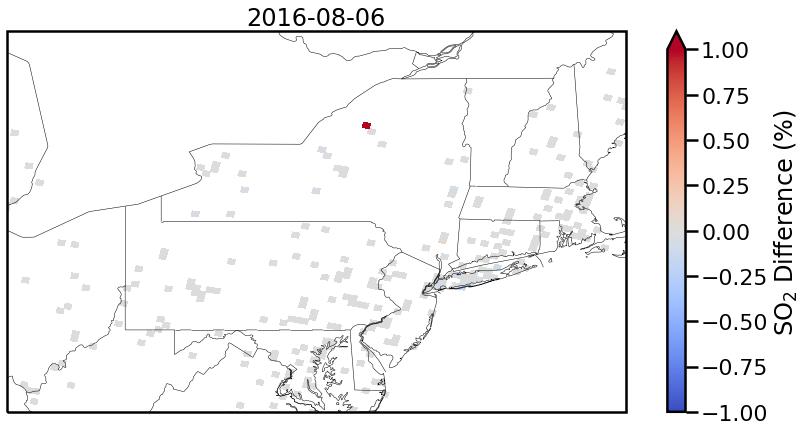

In [7]:
# Plot the mean difference in NOx
so2_pct_diff = (e1.SO2 - e.SO2) / e.SO2
mean_so2_diff = so2_pct_diff.mean(dim='time')
plots.pollution_plot(mean_so2_diff, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm'), 
                     extent = [-83, -70, 38, 46],
                     cbar_label='SO$_{2}$ Difference (%)', 
                     titlestr=f'{e1.time.dt.strftime("%Y-%m-%d")[0].values}', savefig=False, figpath=f'../cmaqpy/data/plots/mean_SO2_diff_.png')

2016-08-11 20:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-11 21:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-11 22:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-11 23:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 00:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 01:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 02:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 03:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 04:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 05:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 06:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/monet/plots/mapgen.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=figsize, **kwargs)
/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 07:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 08:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 09:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 10:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 11:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 12:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 13:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 14:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 15:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 16:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 17:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 18:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 19:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


2016-08-12 20:00


/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


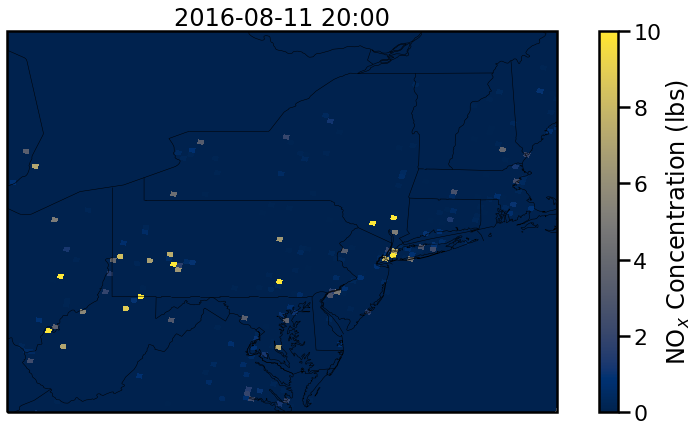

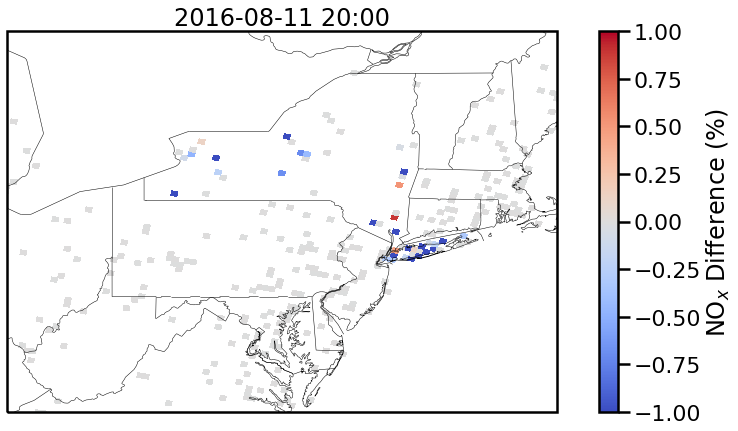

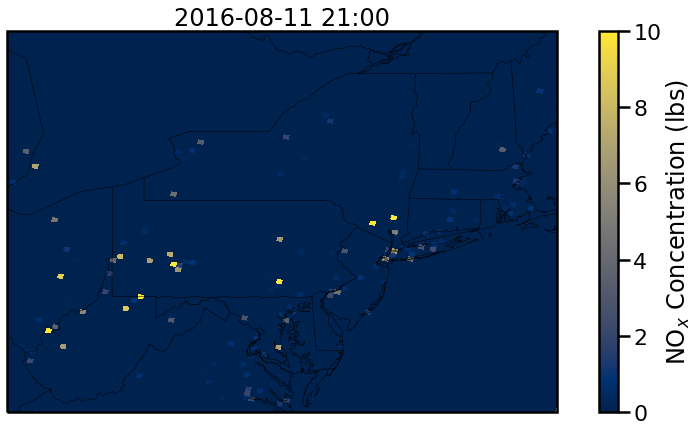

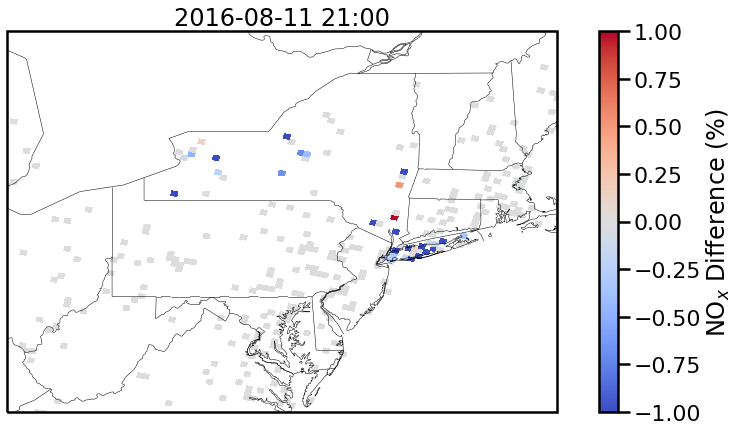

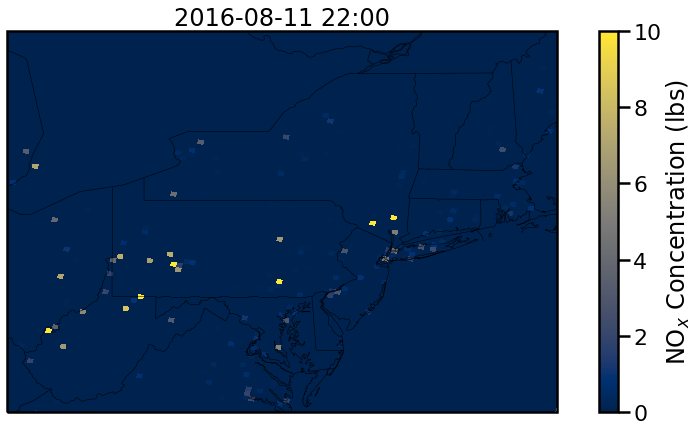

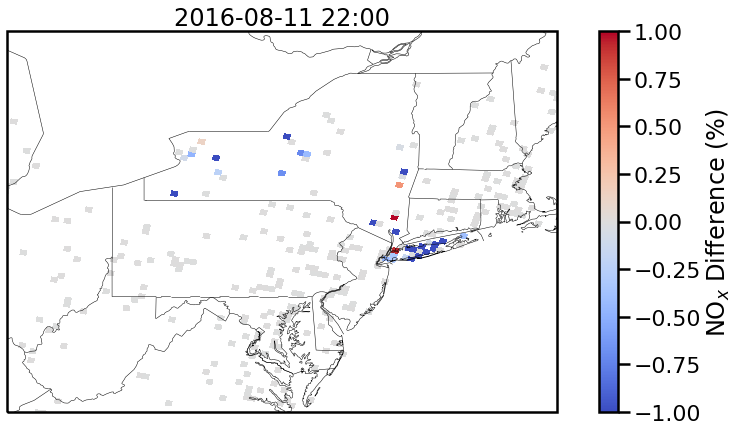

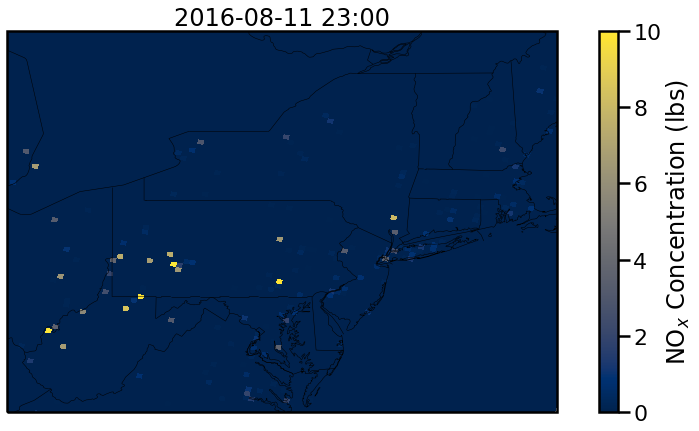

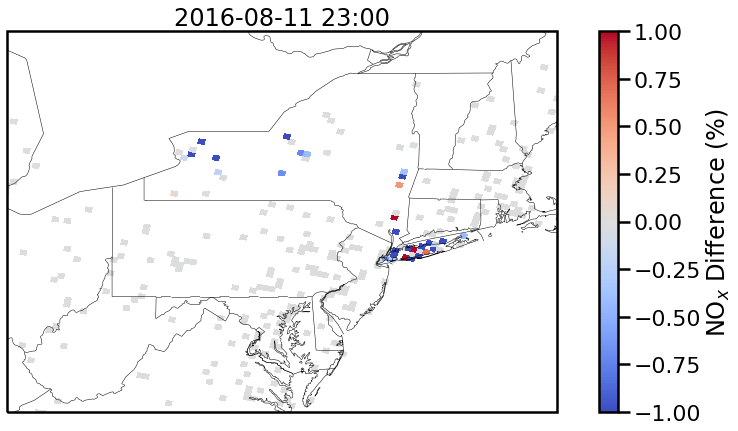

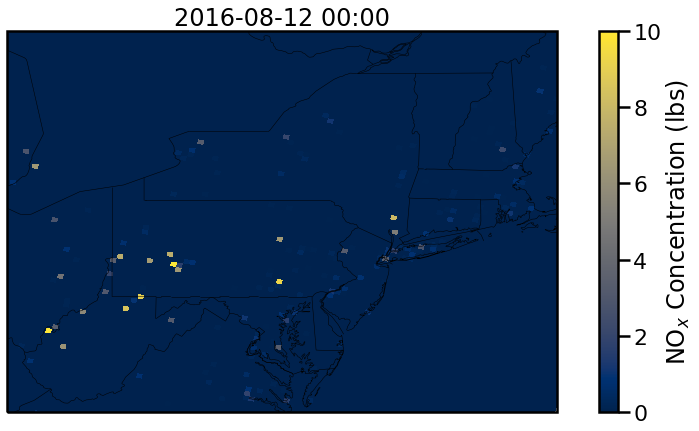

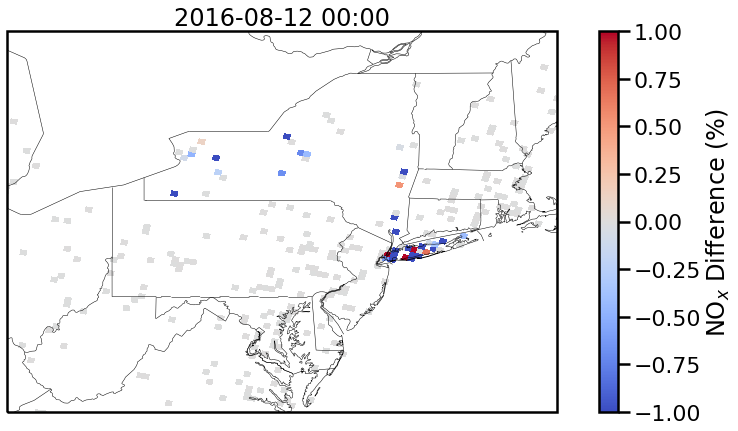

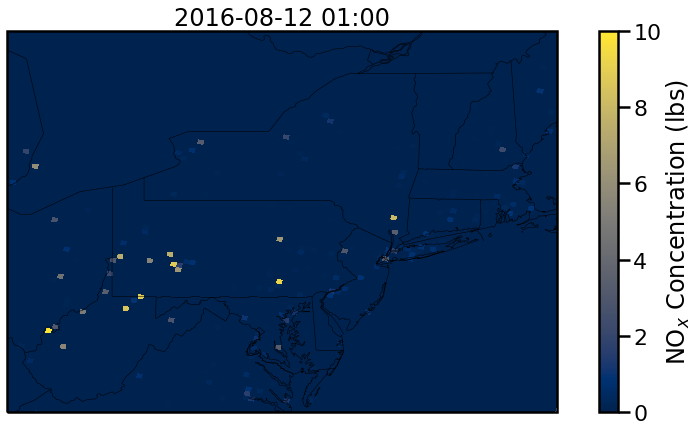

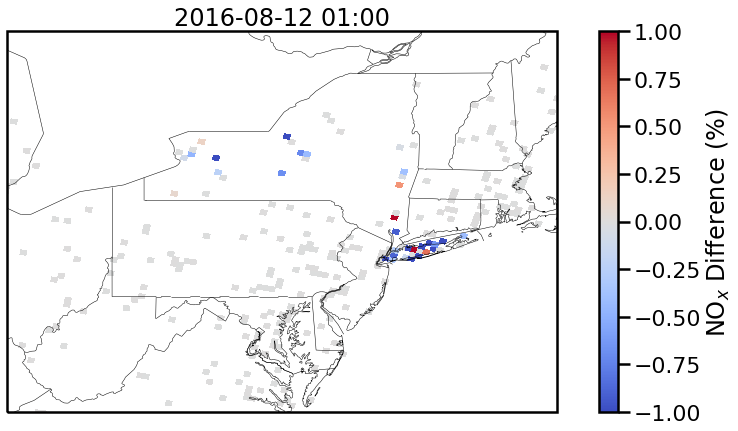

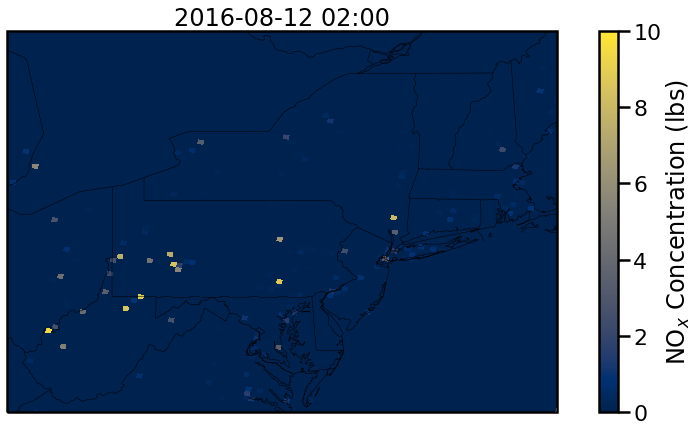

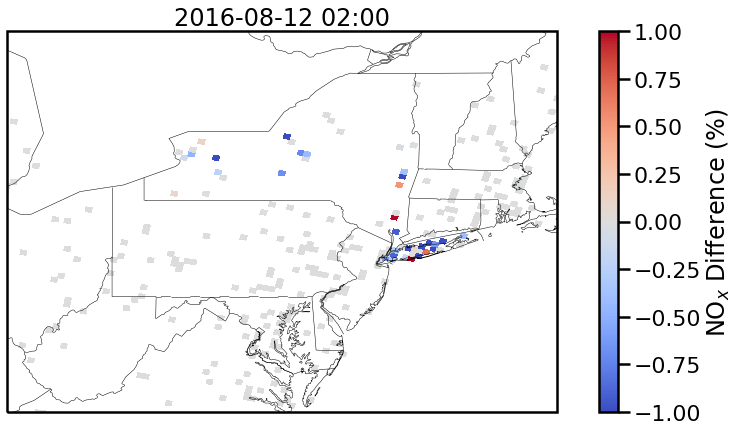

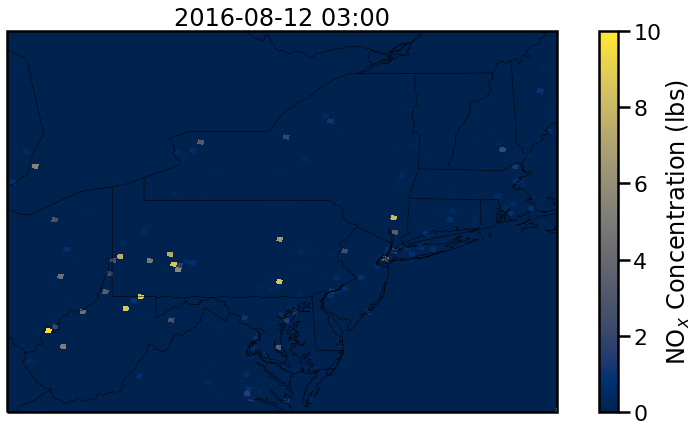

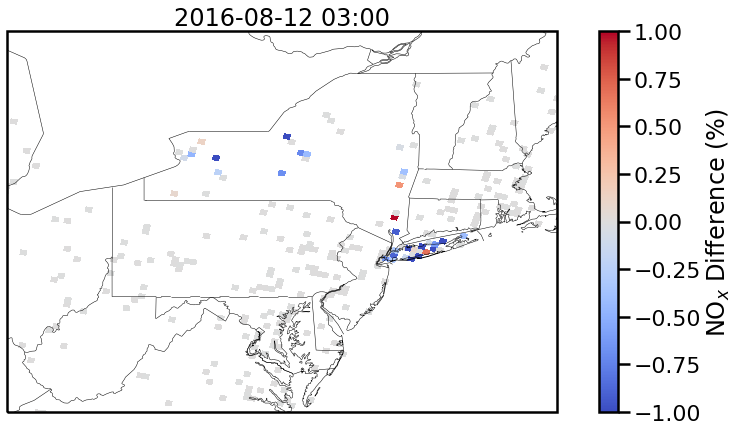

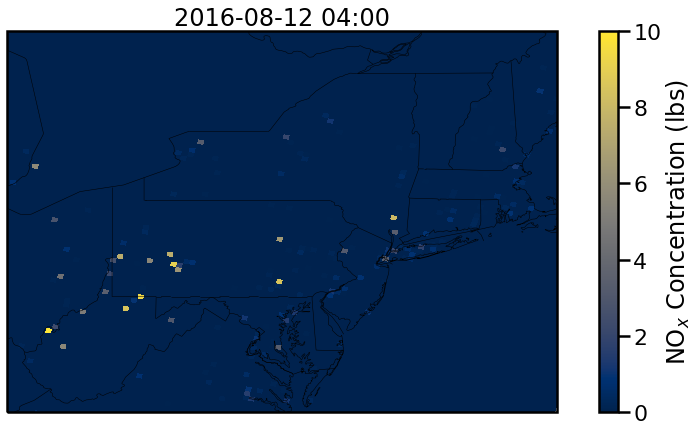

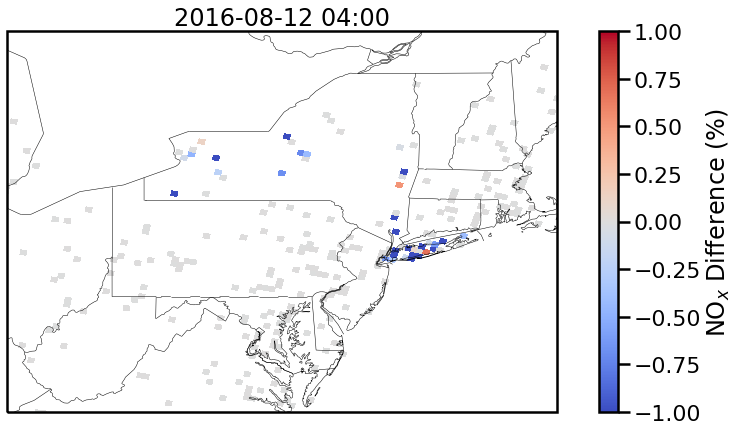

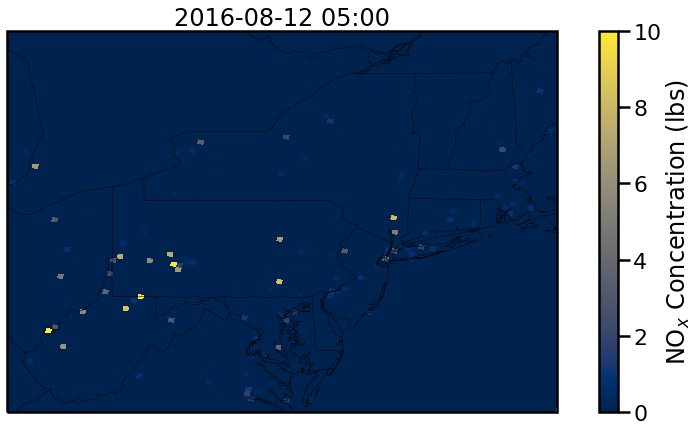

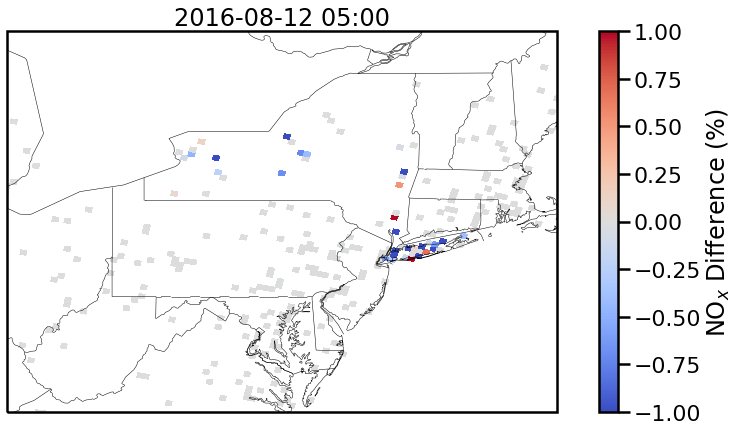

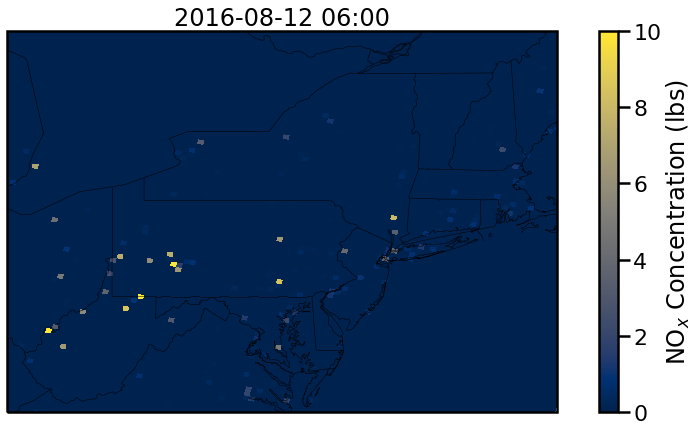

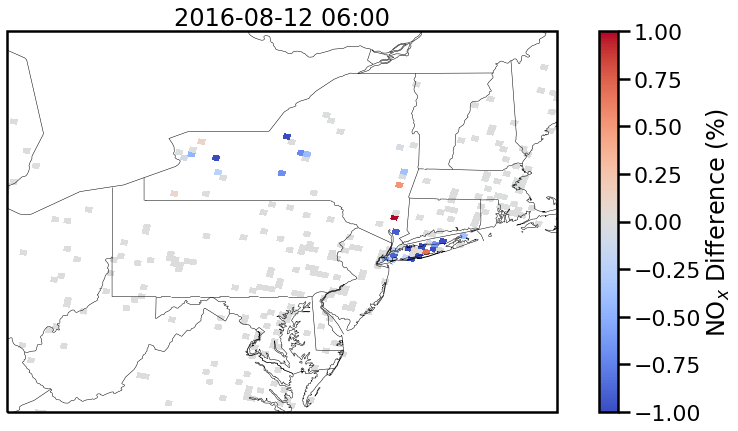

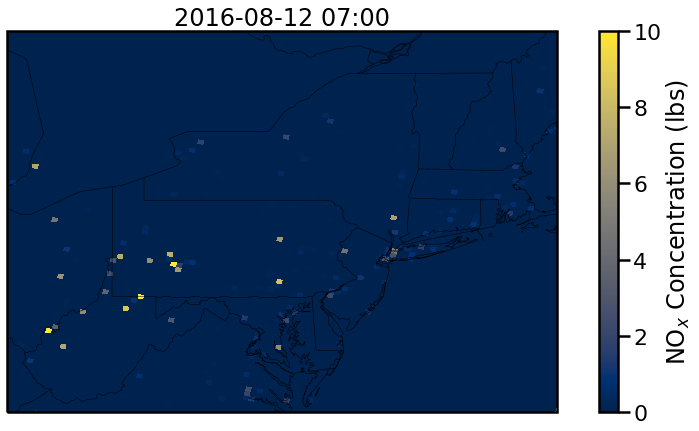

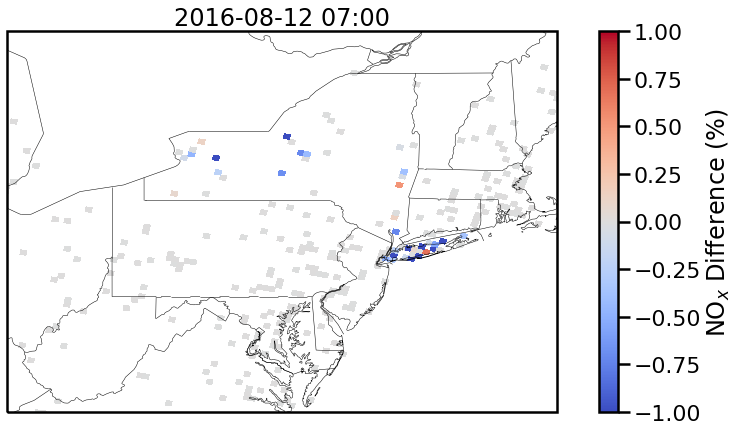

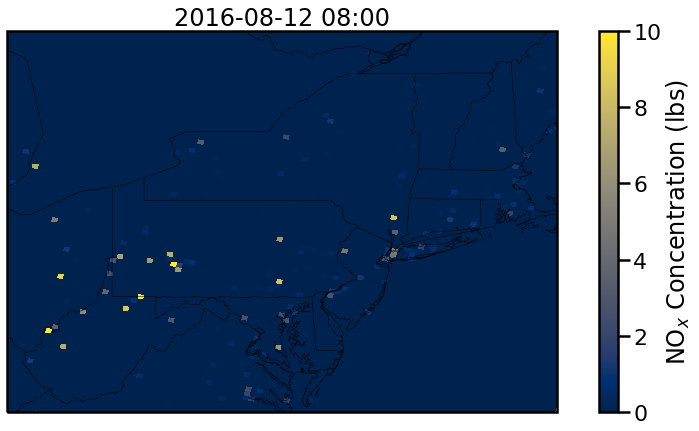

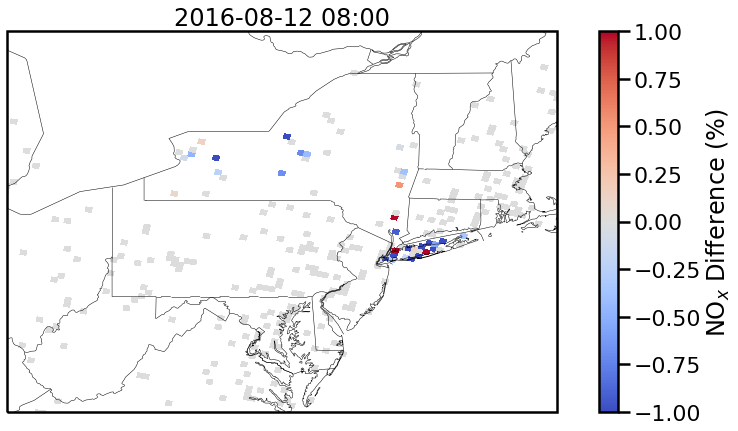

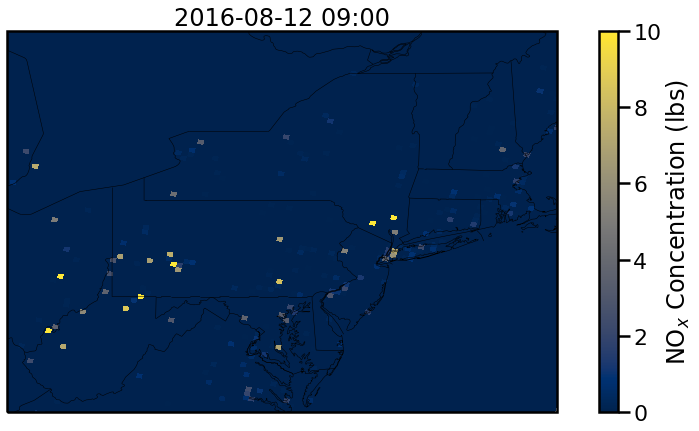

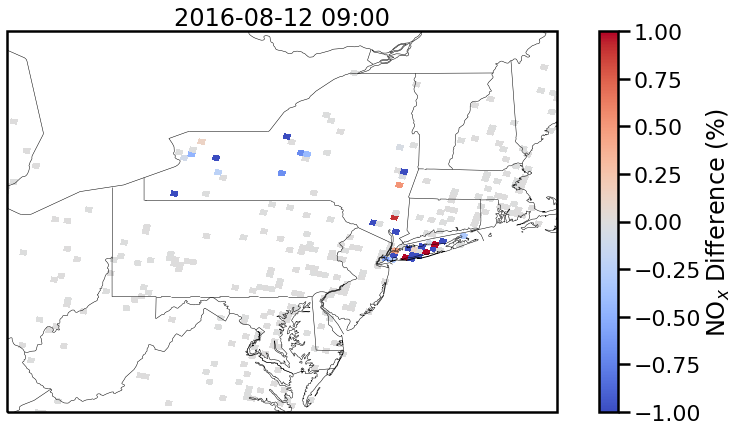

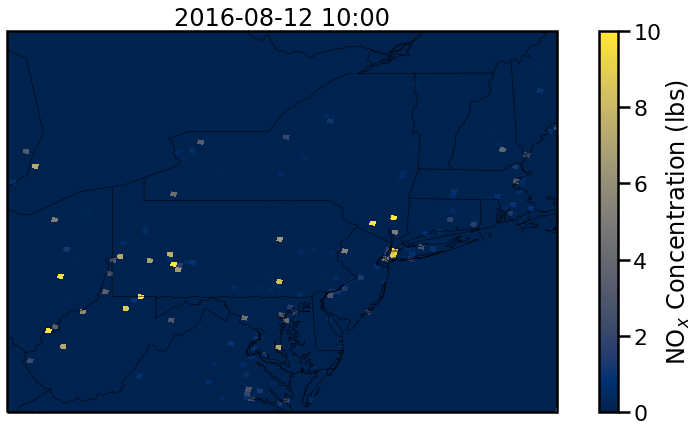

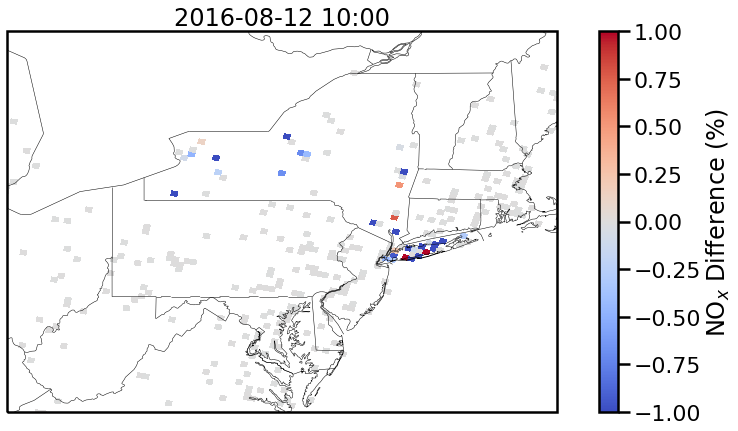

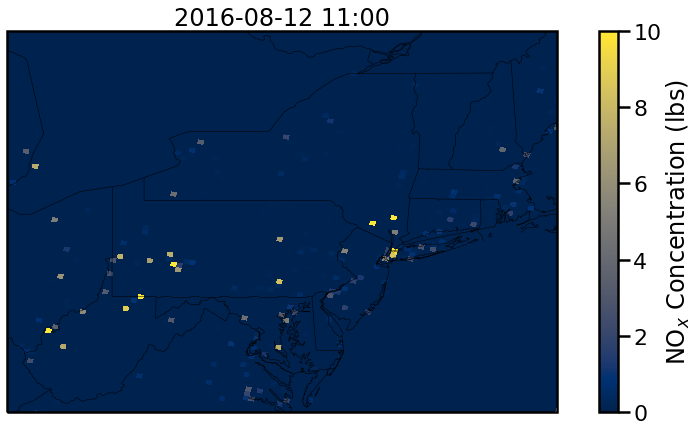

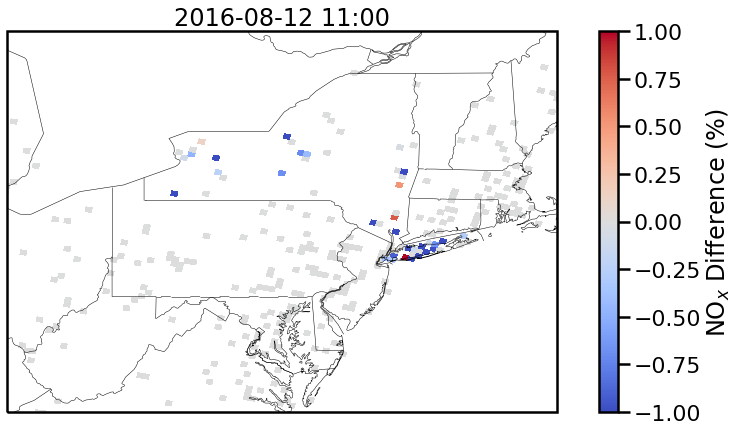

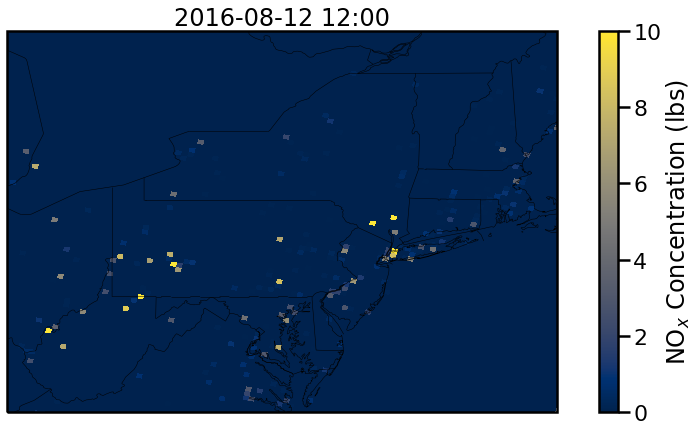

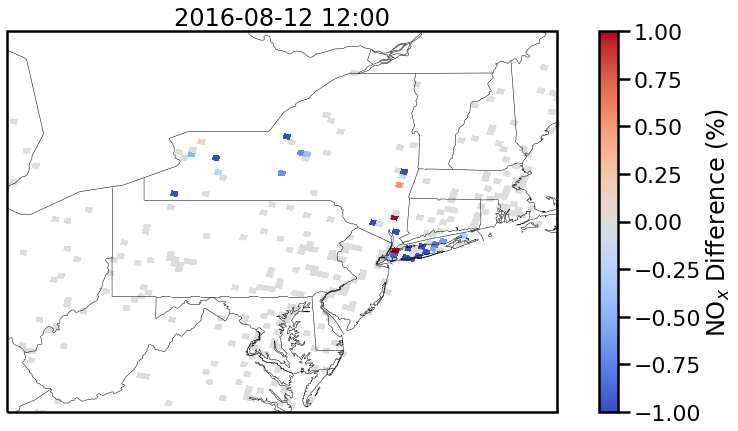

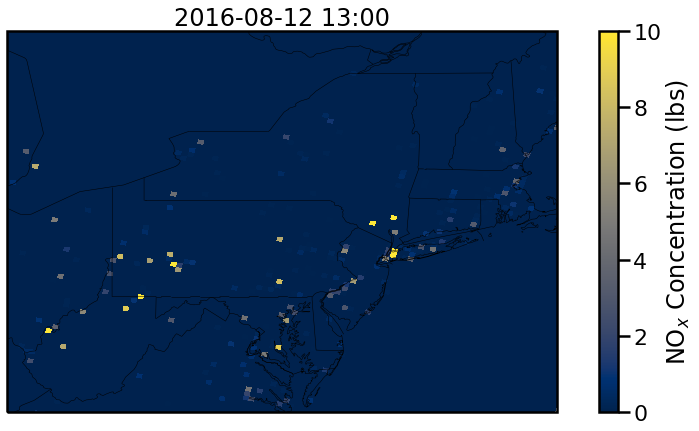

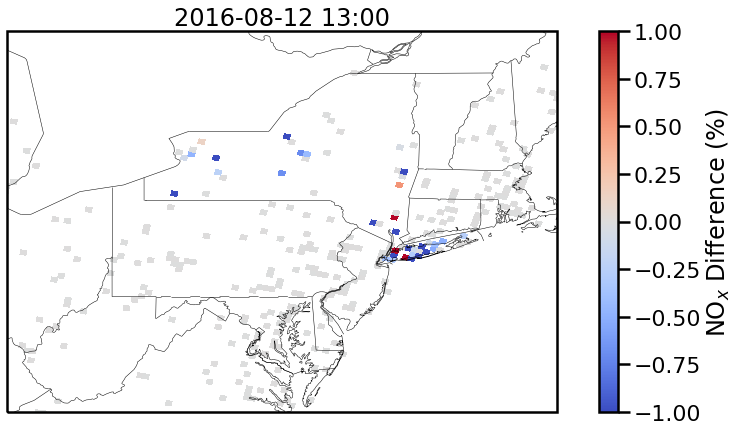

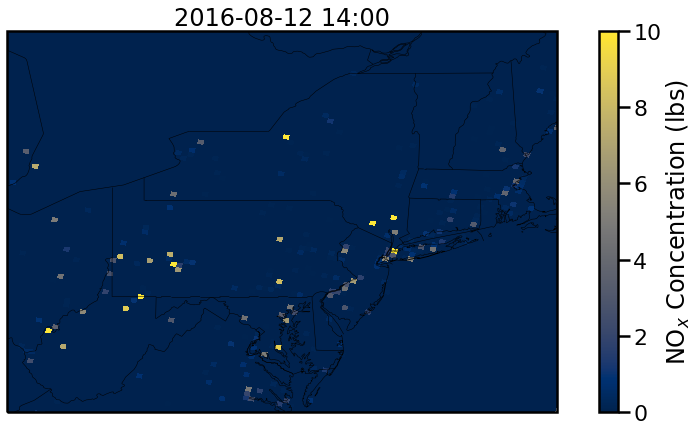

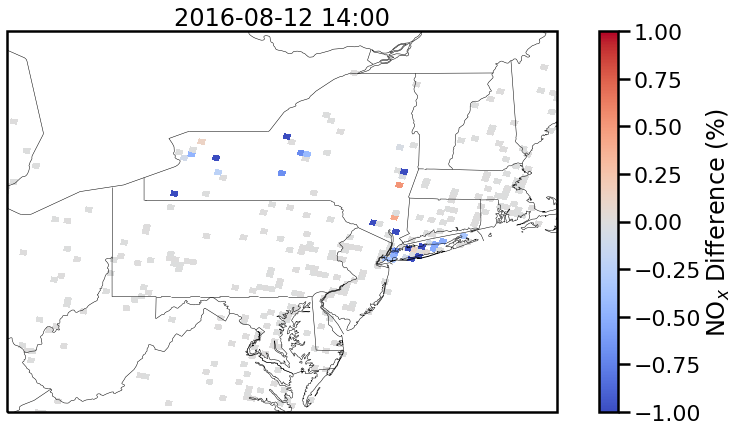

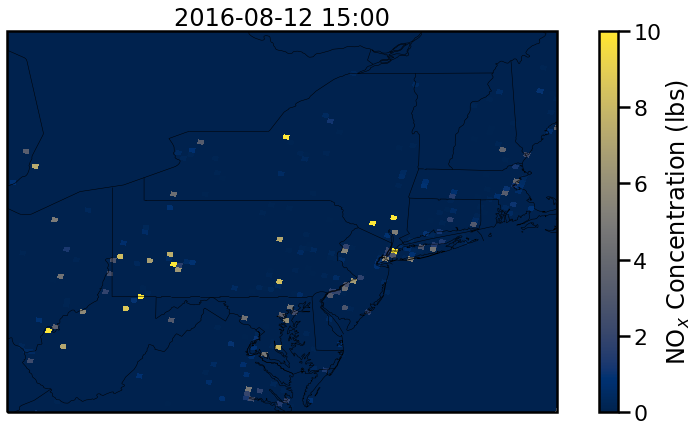

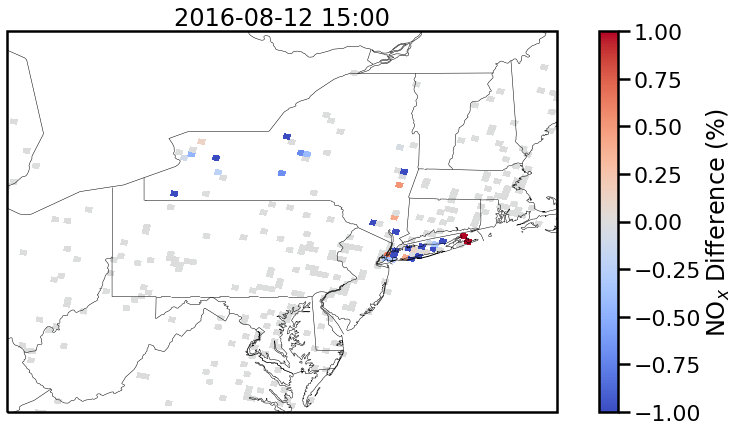

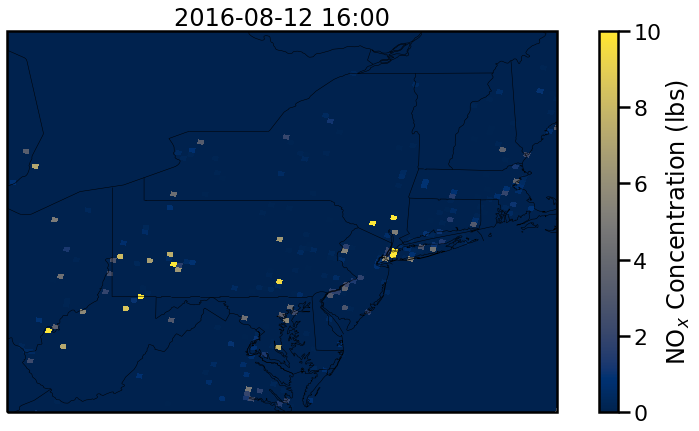

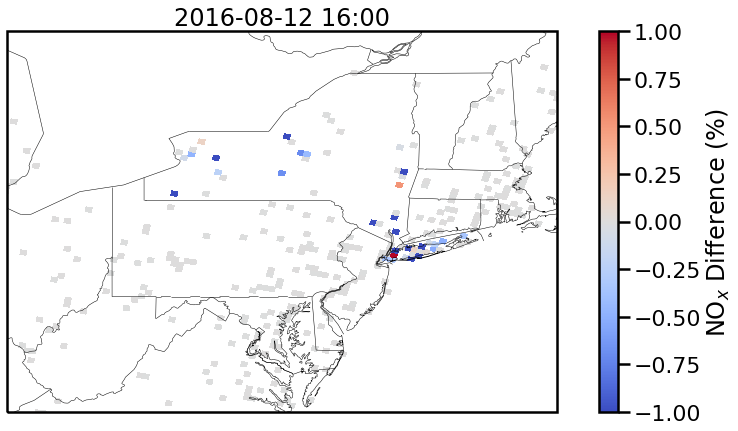

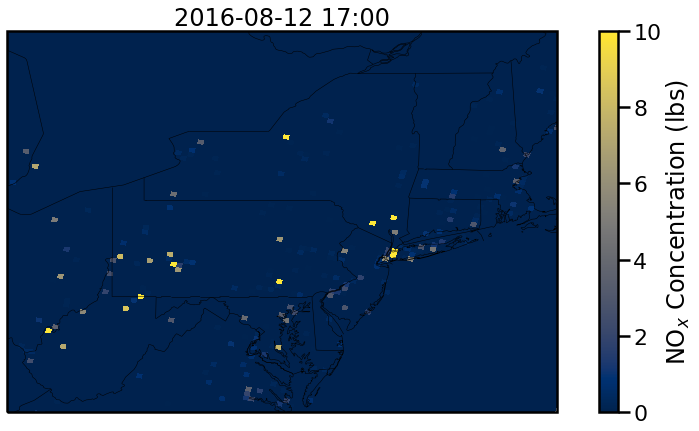

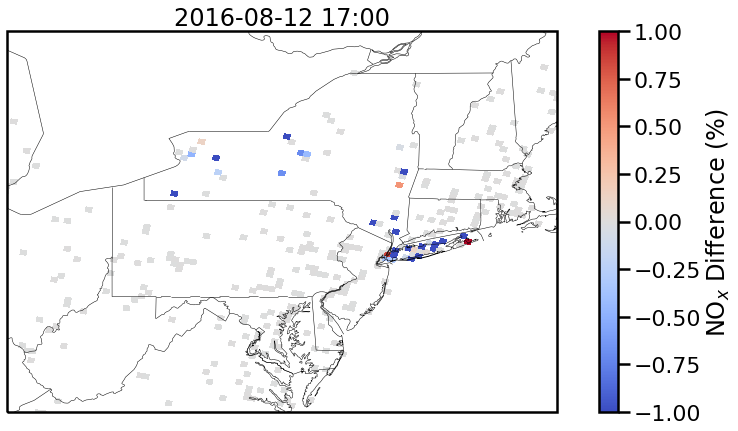

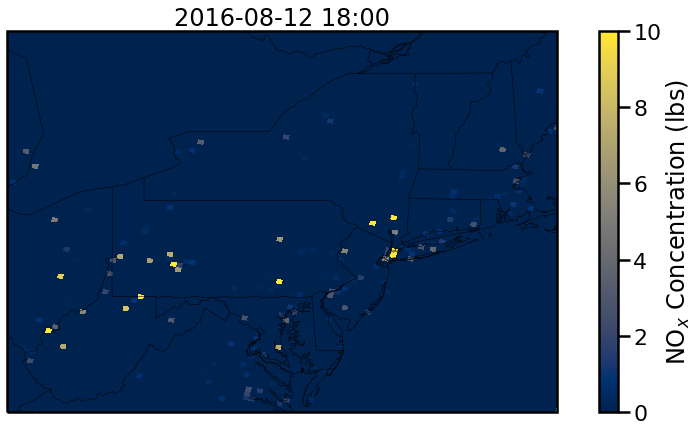

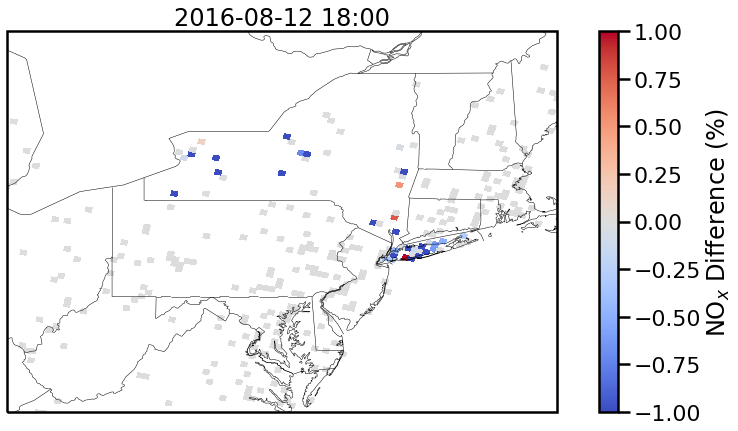

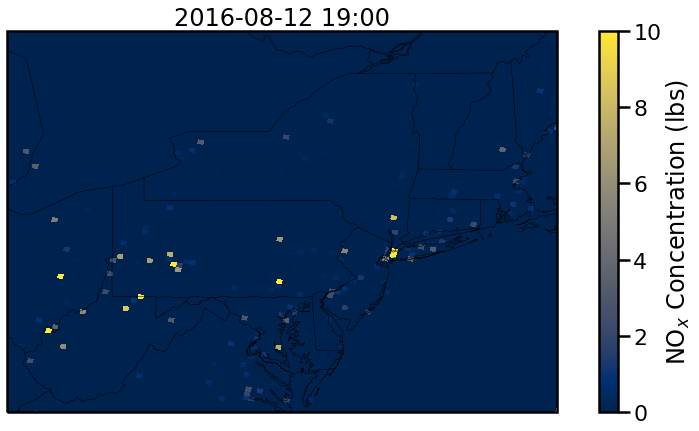

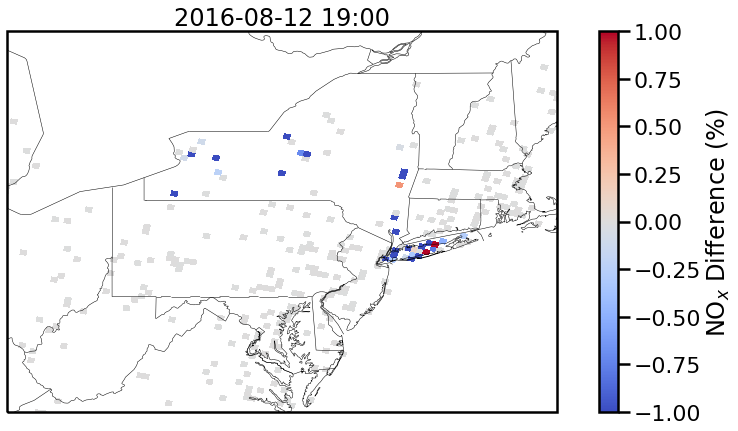

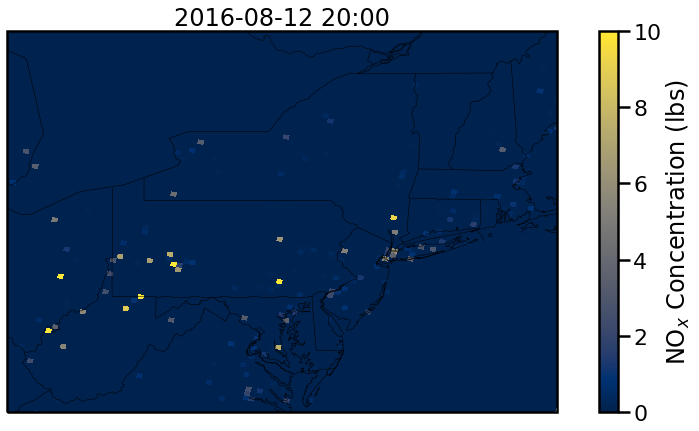

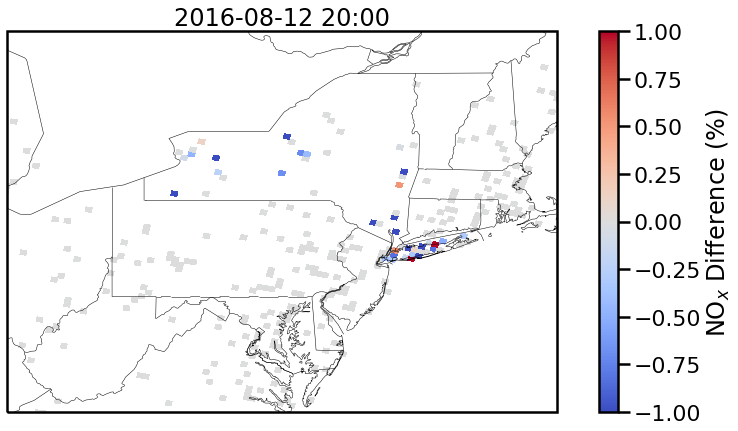

In [48]:
# This plots the difference in Nox for each time slice
for ts in e.time:
    tstr = ts.dt.strftime("%Y-%m-%d %H:%M").values
    print(tstr)
    ts = ts.values
    nox = e.NO.sel(time=ts) + e.NO2.sel(time=ts)
    nox_diff =  e.NO.sel(time=ts) + e.NO2.sel(time=ts) - e_base.NO.sel(time=ts) - e_base.NO2.sel(time=ts)
    nox_pct_diff = (e.NO.sel(time=ts) + e.NO2.sel(time=ts) - e_base.NO.sel(time=ts) - e_base.NO2.sel(time=ts)) / (e_base.NO.sel(time=ts) + e_base.NO2.sel(time=ts)) * 100
    plots.conc_compare(nox, nox_pct_diff, vmin1=0, vmax1=10, vmin2=-1, vmax2=1, 
                       cmap1=cm.get_cmap('cividis'), cmap2=cm.get_cmap('coolwarm'), 
                       extent = [-83, -70, 37, 46], 
                       cbar_label1='NO$_{x}$ Concentration (lbs)', cbar_label2='NO$_{x}$ Difference (%)', 
                       titlestr1=tstr, titlestr2=tstr, savefig=True, 
                       figpath1=f'../cmaqpy/data/plots/NOx_{tstr}.png', figpath2=f'../cmaqpy/data/plots/NOx_diff_{tstr}.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonic

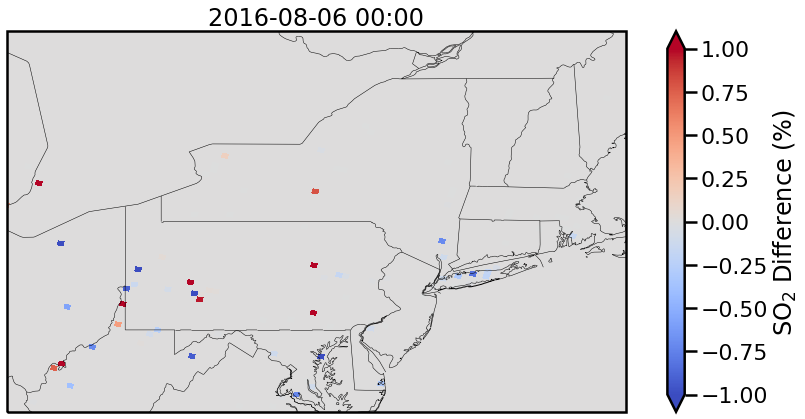

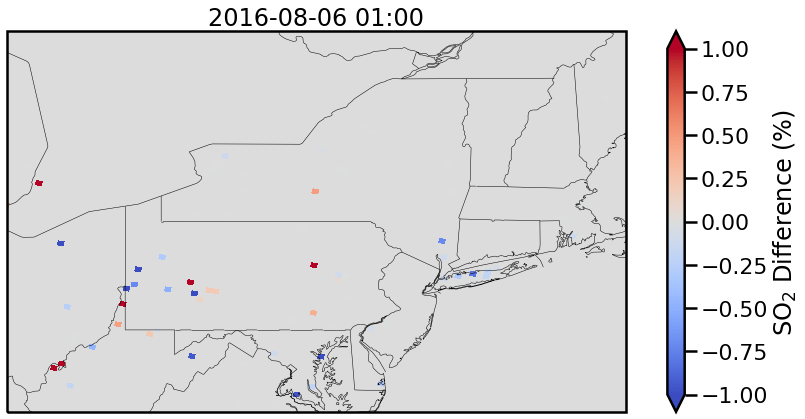

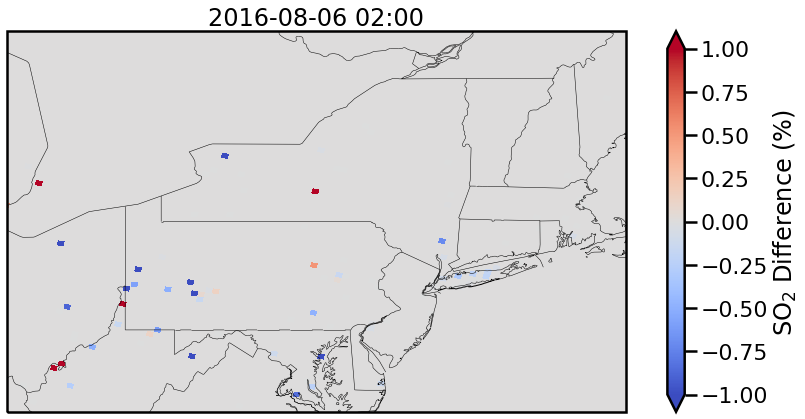

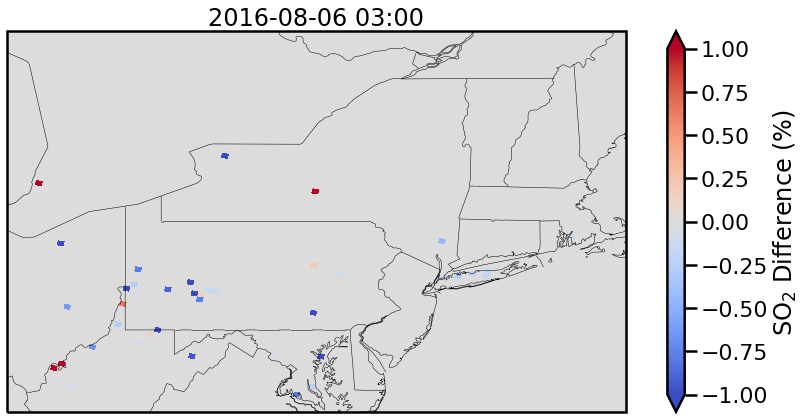

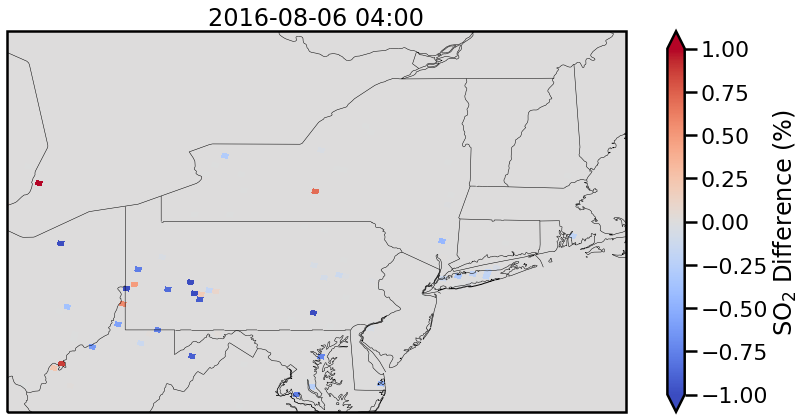

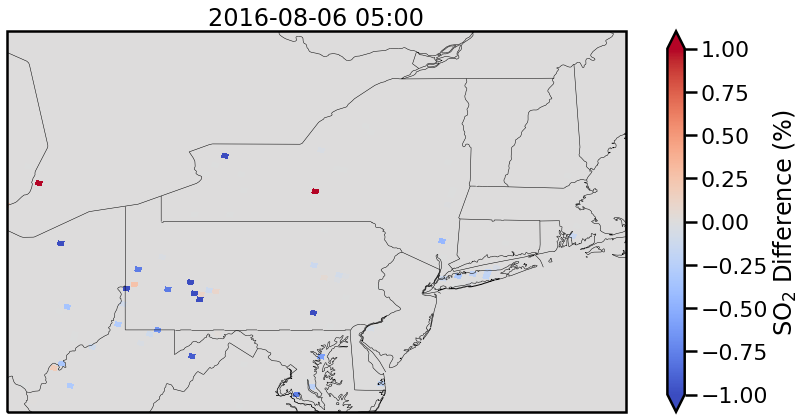

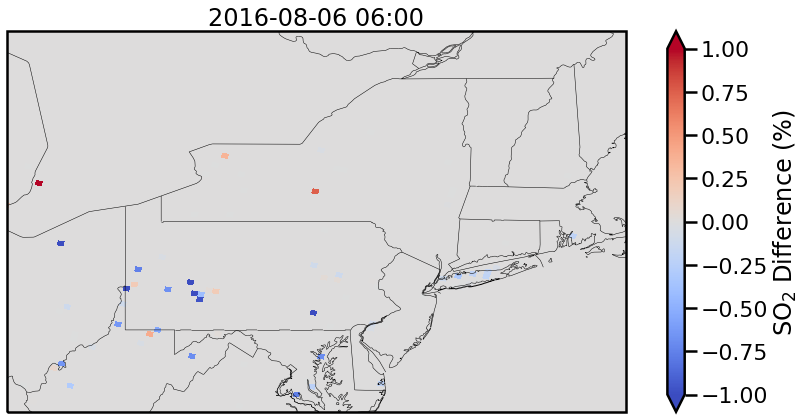

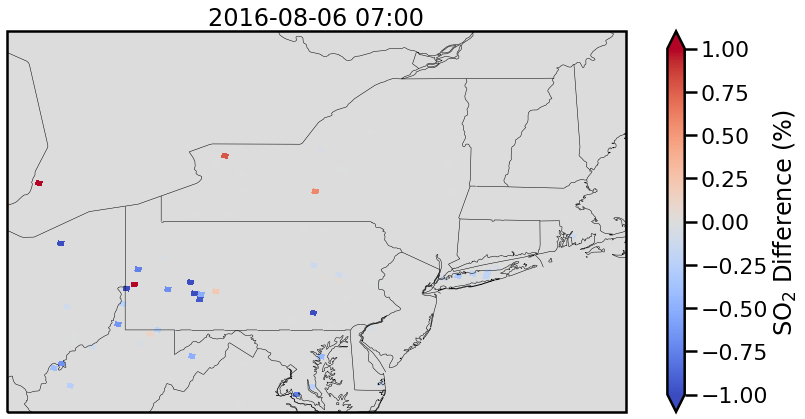

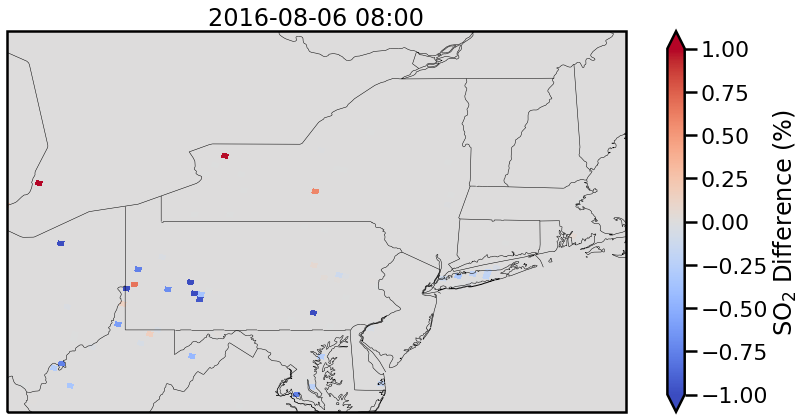

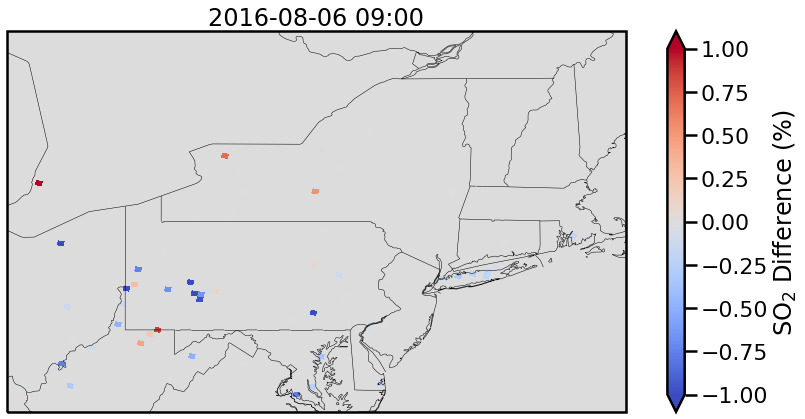

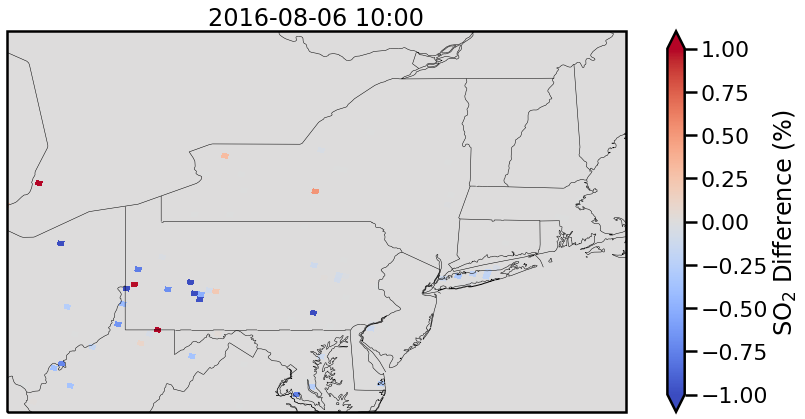

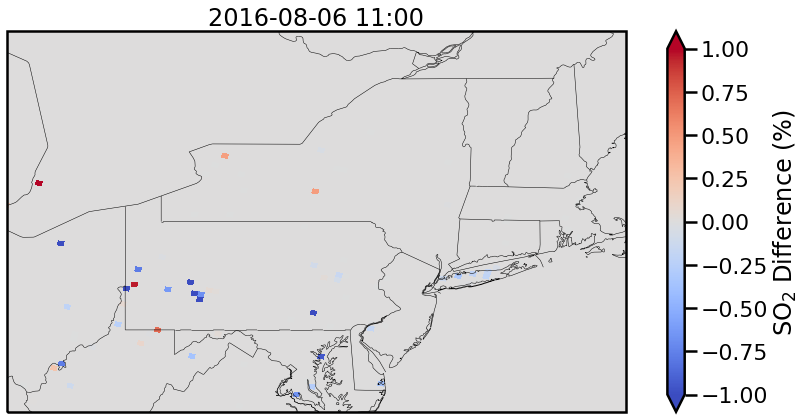

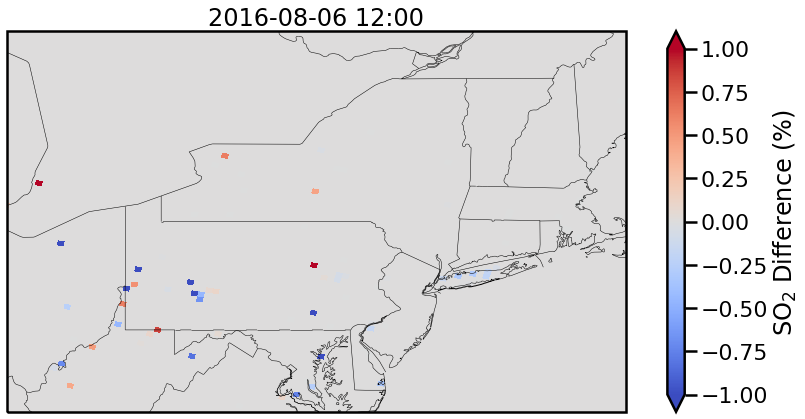

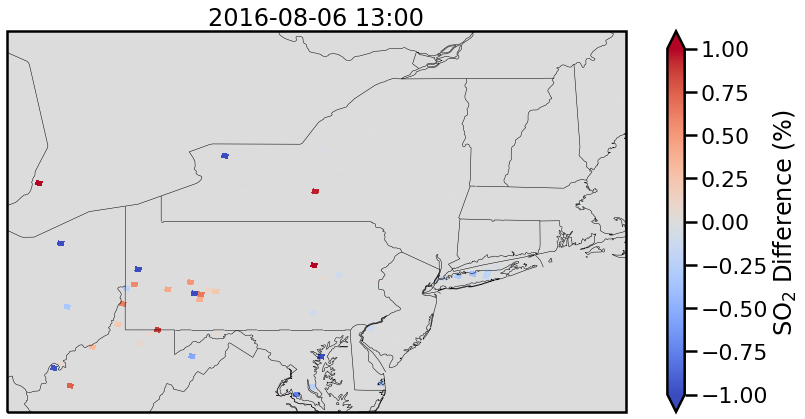

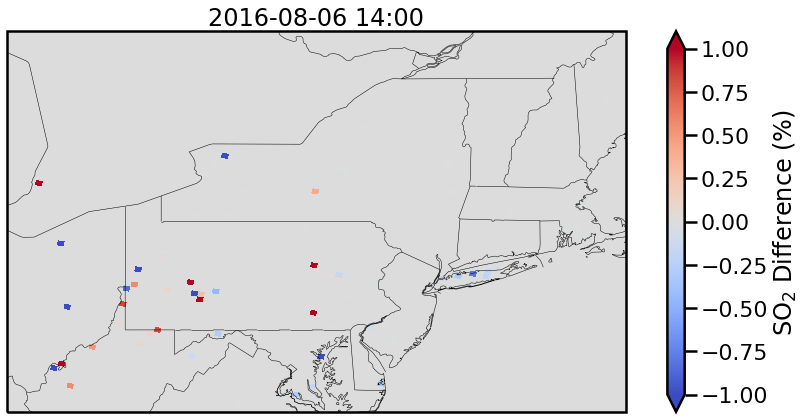

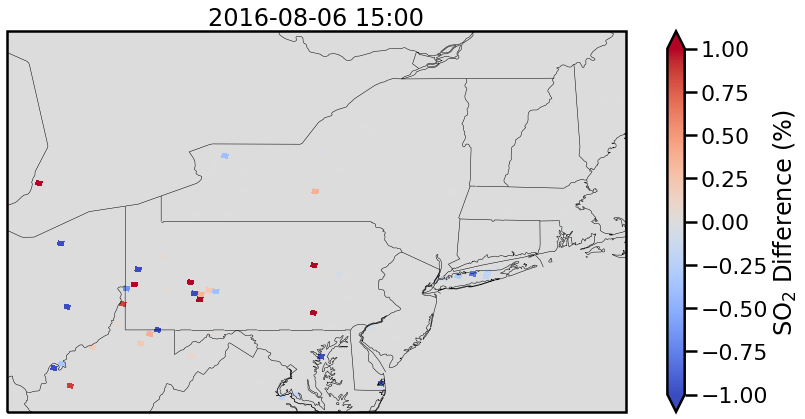

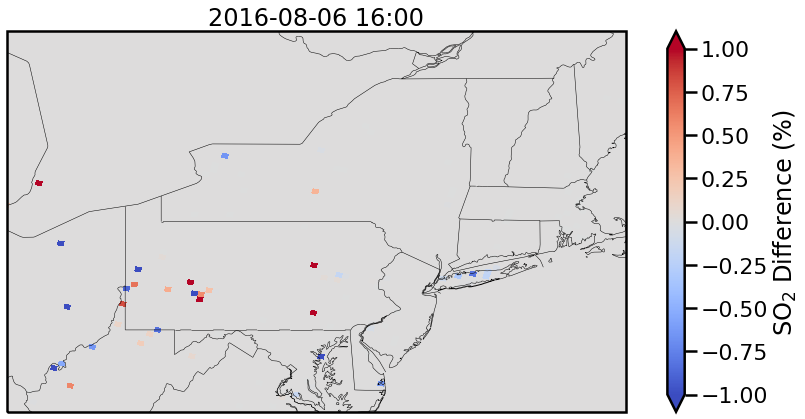

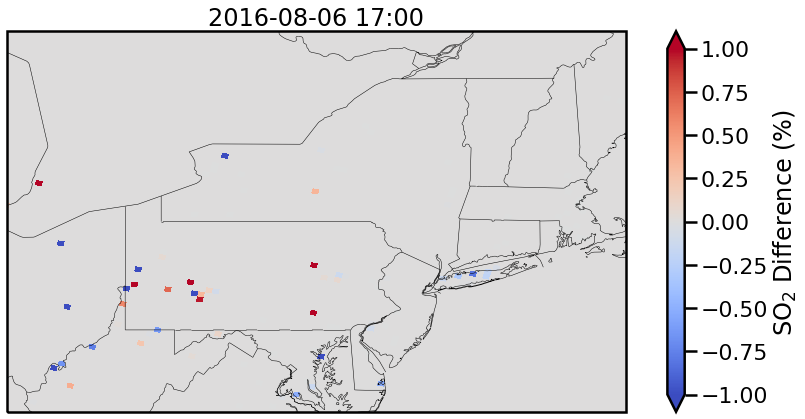

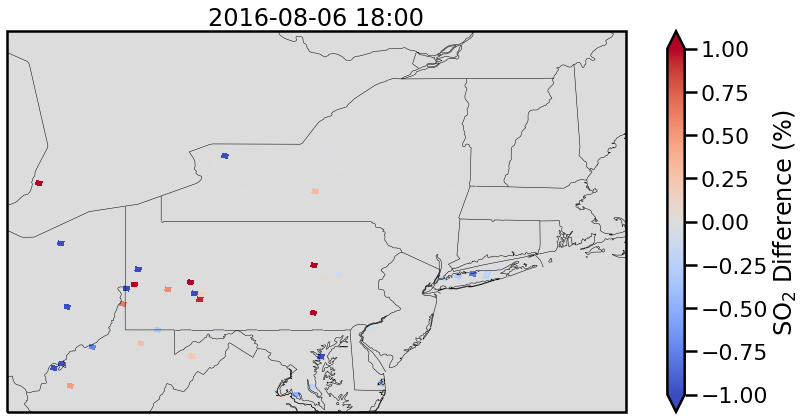

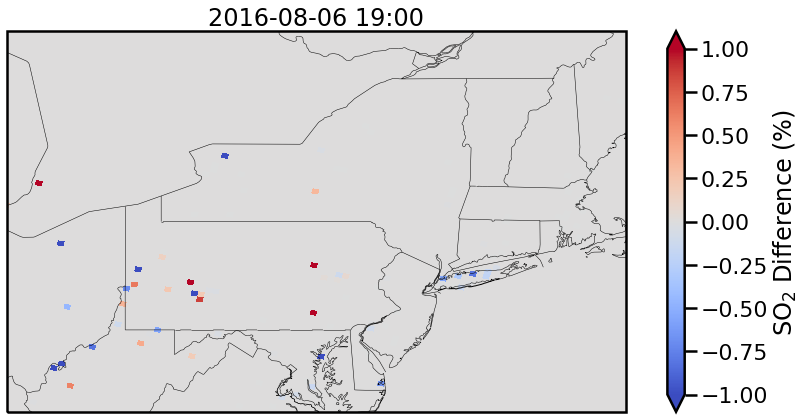

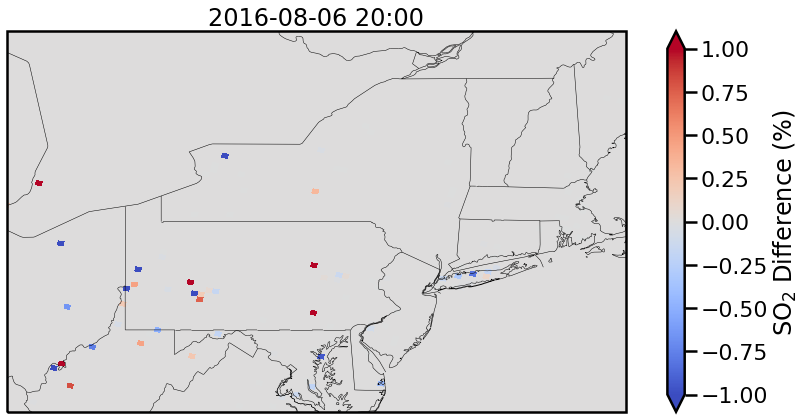

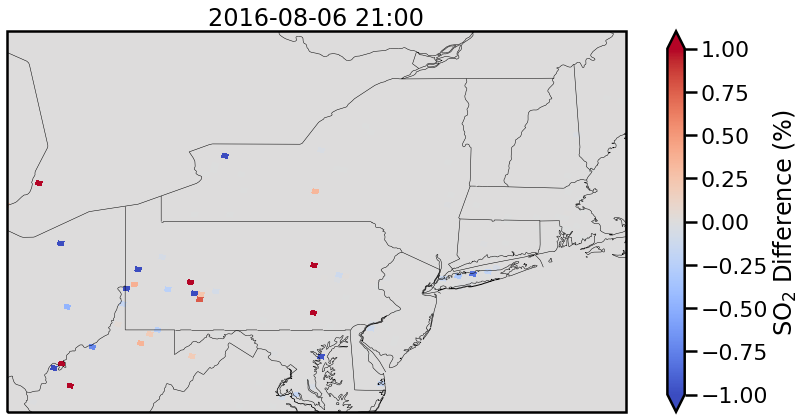

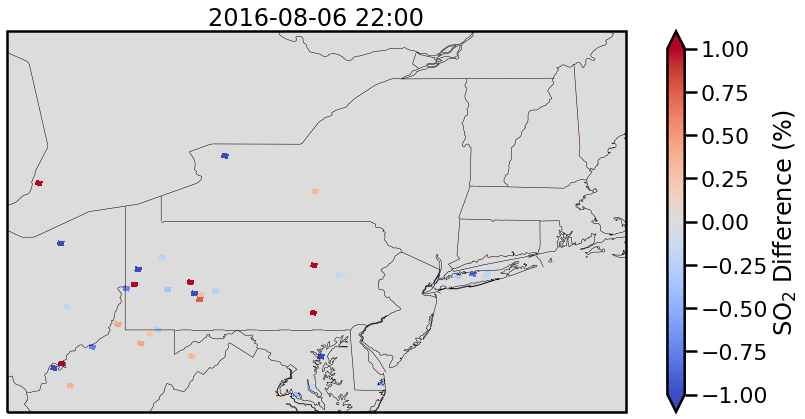

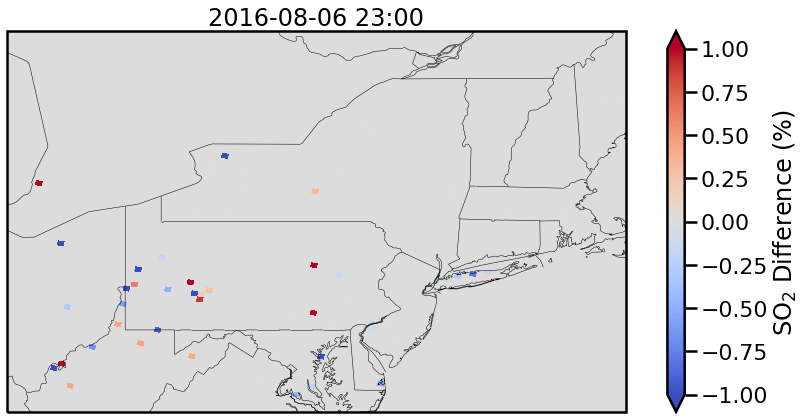

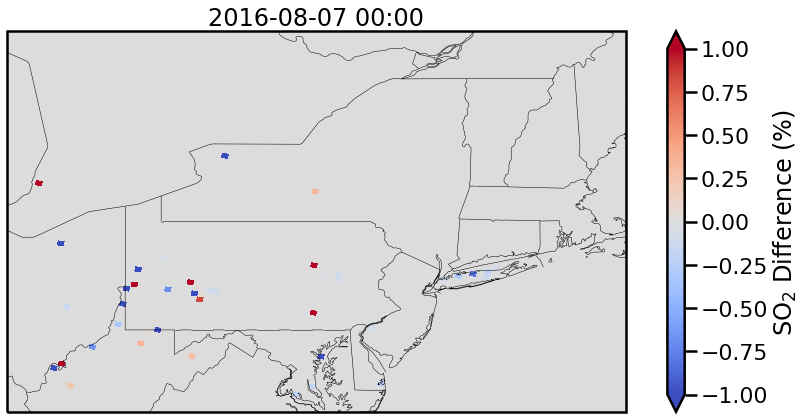

In [8]:
# This plots the difference in SO2 for each time slice
for ts in e.time:
    tstr = ts.dt.strftime("%Y-%m-%d %H:%M").values
    ts = ts.values
    nox_diff = e.SO2.sel(time=ts) - e1.SO2.sel(time=ts)
    plots.pollution_plot(nox_diff, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm'), 
                         extent = [-83, -70, 38, 46],
                         cbar_label='SO$_{2}$ Difference (%)',
                         titlestr=tstr, savefig=True, figpath=f'../cmaqpy/data/plots/SO2_diff_{tstr}.png')